In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install nctoolkit


In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import glob
import os
from tqdm import tqdm
from multiprocessing import Pool
import nctoolkit as nc

Please install CDO version 1.9.7 or above: https://code.mpimet.mpg.de/projects/cdo/ or https://anaconda.org/conda-forge/cdo


##1. extract the 10x10 pixels value
- Dates, rainfall and temperature use the same dataframe for single pixel model
- Extract the 10x10 pixels NDVI and DEM value

In [ ]:
# Extract the 10x10 pixels NDVI value and save in csv file

dir_path = r'/content/drive/MyDrive/train/'

output_file = open('output_NDVI_10x10_raw.txt', 'w')

def process_file(file):
    with xr.open_dataset(file) as minicube:
        minicube = minicube.isel(time=slice(4, None, 5))
        nir = minicube.s2_B8A
        red = minicube.s2_B04
        mask = minicube.s2_mask

        ndvi = ((nir - red) / (nir + red + 1e-8)).where(mask == 0, np.NaN)
        minicube["s2_ndvi"] = ndvi

        ndvi_c = ndvi.isel(lat=slice(64-5, 64+5), lon=slice(64-5, 64+5))
        values = ndvi_c.values.reshape(ndvi_c.shape[0], -1)
        return ' '.join(' '.join(str(value) for value in row) for row in values) + '\n'

file_list = []
for subdir, dirs, files in os.walk(dir_path):
    for file in files:
        filepath = os.path.join(subdir, file)
        if filepath.endswith('.nc'):
            file_list.append(filepath)

with Pool() as p:
    results = list(tqdm(p.imap(process_file, file_list), total=len(file_list), desc='Processing files'))

# Write the results to the output file
output_file.writelines(results)
output_file.close()


In [ ]:
# Average the extracted 10x10 pixels NDVI value and save in a new csv file

with open('/content/drive/MyDrive/output_NDVI_10x10_raw.txt', 'r') as f:
    raw_ndvi_lines = f.readlines()

# Calculate the average NDVI value for each timestep
avg_ndvi_values = []
for line in raw_ndvi_lines:
    ndvi_values = np.array([float(value) for value in line.split()])
    ndvi_values_reshaped = ndvi_values.reshape(-1, 100)  # Reshape the flattened values into a 2D array with 30 rows (time steps) and 100 columns (pixels)
    avg_ndvi_per_timestep = np.nanmean(ndvi_values_reshaped, axis=1)  # Calculate the average NDVI value for each row (time step)
    avg_ndvi_values.append(avg_ndvi_per_timestep)

# Save the average NDVI values to a new file
with open('output_NDVI_10x10_avg.txt', 'w') as f:
    for avg_ndvi_per_timestep in avg_ndvi_values:
        f.write(' '.join(str(value) for value in avg_ndvi_per_timestep) + '\n')


Mean of empty slice


In [ ]:
# Extract the 10x10 pixels DEM value and save in csv file

dir_path = r'/content/drive/MyDrive/train/'

# Load all the netCDF files into a single xarray dataset
dataset = xr.open_mfdataset(os.path.join(dir_path, '**/*.nc'))

# Extract the time slice you want and flatten the data
dem_c = dataset['nasa_dem'].isel(lat=slice(64-5, 64+5), lon=slice(64-5, 64+5))

# Open the text file to save the data
output_file = open('output_dem_10x10_raw.txt', 'w')

# Loop through the flattened data, write it to the output file, and track progress with tqdm
with output_file as f, tqdm(desc='Processing data', total=len(dem_c.values.flatten())) as pbar:
    for value in dem_c.values.flatten():
        f.write(str(value) + ' ')
        pbar.update(1)

# Close the output file
output_file.close()

In [ ]:
# Average the extracted 10x10 pixels NDVI value and save in a new csv file

# Read the output file with 10x10 DEM values
with open('output_DEM_10x10_raw.txt', 'r') as f:
    raw_dem_lines = f.readlines()

# Calculate the average DEM value for each timestep
avg_dem_values = []
for line in raw_dem_lines:
    dem_values = np.array([float(value) for value in line.split()])
    avg_dem = np.nanmean(dem_values)
    avg_dem_values.append(avg_dem)

# Save the average DEM values to a new file
with open('output_DEM_10x10_avg.txt', 'w') as f:
    for avg_dem in avg_dem_values:
        f.write(str(avg_dem) + '\n')

# 2. Prepare the data and merge in one table

In [ ]:
# Load the tables of all values needed
dates_df = pd.read_csv('output_dates.txt',header=None, sep='\s')
ndvi_df_avg = pd.read_csv('output_NDVI_10x10_avg.txt',header=None, sep='\s')
ndvi_df = pd.read_csv('/content/drive/MyDrive/output_NDVI_10x10_raw.txt',header=None, sep='\s')
rainfall_df = pd.read_csv('output_rainfall.txt',header=None, sep='\s')
temp_df = pd.read_csv('output_temp.txt',header=None, sep='\s')
dem_df_avg = pd.read_csv('output_dem_10x10_avg.txt',header=None, sep='\s')
dem_df = pd.read_csv('output_dem_10x10_raw.txt',header=None, sep='\s')

In [ ]:
# let all dataframe has same length
common_indices = dates_df.index.intersection(rainfall_df.index).intersection(temp_df.index)

ndvi_df_avg = ndvi_df_avg.loc[common_indices]
ndvi_df = ndvi_df.loc[common_indices]
dem_df_avg = dem_df_avg.loc[common_indices]
dem_df = dem_df.loc[common_indices]


In [ ]:
# give each table the ID
dates_df = dates_df.rename_axis('Pixel_ID').reset_index()
ndvi_df_avg = ndvi_df_avg.rename_axis('Pixel_ID').reset_index()
rainfall_df = rainfall_df.rename_axis('Pixel_ID').reset_index()
temp_df = temp_df.rename_axis('Pixel_ID').reset_index()
dem_df_avg = dem_df_avg.rename_axis('Pixel_ID').reset_index()

dem_df_multi = dem_df.rename_axis('Pixel_ID').reset_index()
ndvi_df_multi = ndvi_df.rename_axis('Pixel_ID').reset_index()

In [ ]:
dem_df_multi

## 2.1 To prepare for the merged table with average pixel

In [ ]:
# to prepare for the merged table evg: dates, rainfall, temp, ndvi_avg, dem_avg

# add variable name to the column
for i in range(1,31):
    dates_df = dates_df.rename(columns={dates_df.columns[i]: f"Date {i}"})    
    rainfall_df = rainfall_df.rename(columns={rainfall_df.columns[i]: f"Rainfall {i}"})
    temp_df = temp_df.rename(columns={temp_df.columns[i]: f"Temperature {i}"})
    ndvi_df_avg = ndvi_df_avg.rename(columns={ndvi_df_avg.columns[i]: f"NDVI {i}"})

dem_df_avg = dem_df_avg.rename(columns={0: 'DEM'})

In [ ]:
#Add timesteps column and sort by pixel_ID for each table

#NDVI_avg
#add timesteps column
ndvi_df_avg = pd.melt(ndvi_df_avg, id_vars=['Pixel_ID'], var_name='Timestep', value_name='NDVI')
# Extract the timestep number from the 'Timestep' column
ndvi_df_avg['Timestep'] = ndvi_df_avg['Timestep'].str.extract('(\d+)', expand=False).astype(int)
# Sort by Pixel_ID and Timestep
ndvi_df_avg = ndvi_df_avg.sort_values(['Pixel_ID', 'Timestep']).reset_index(drop=True)

#Dates
#add timesteps column
dates_df = pd.melt(dates_df, id_vars=['Pixel_ID'], var_name='Timestep', value_name='Date')
# Extract the timestep number from the 'Timestep' column
dates_df['Timestep'] = dates_df['Timestep'].str.extract('(\d+)', expand=False).astype(int)
# Sort by Pixel_ID and Timestep
dates_df = dates_df.sort_values(['Pixel_ID', 'Timestep']).reset_index(drop=True)

#Rainfall
#add timesteps column
rainfall_df = pd.melt(rainfall_df, id_vars=['Pixel_ID'], var_name='Timestep', value_name='Rainfall')
# Extract the timestep number from the 'Timestep' column
rainfall_df['Timestep'] = rainfall_df['Timestep'].str.extract('(\d+)', expand=False).astype(int)
# Sort by Pixel_ID and Timestep
rainfall_df = rainfall_df.sort_values(['Pixel_ID', 'Timestep']).reset_index(drop=True)

#Temperature
#add timesteps column
temp_df = pd.melt(temp_df, id_vars=['Pixel_ID'], var_name='Timestep', value_name='Temperature')
# Extract the timestep number from the 'Timestep' column
temp_df['Timestep'] = temp_df['Timestep'].str.extract('(\d+)', expand=False).astype(int)
# Sort by Pixel_ID and Timestep
temp_df = temp_df.sort_values(['Pixel_ID', 'Timestep']).reset_index(drop=True)



In [ ]:
#Merge all veriable (avg) tables in one table
merged_table = pd.merge(dates_df, ndvi_df_avg, on=['Pixel_ID', 'Timestep'])
merged_table = pd.merge(merged_table, rainfall_df, on=['Pixel_ID', 'Timestep'])
merged_table = pd.merge(merged_table, temp_df, on=['Pixel_ID', 'Timestep'])
merged_table_avg = pd.merge(merged_table, dem_df_avg, on='Pixel_ID')

merged_table_avg

In [ ]:
merged_table_avg.to_csv('merged_table_avg.csv', index=False)

## 2.2 To prepare for the merged table with multiple pixels

In [ ]:
# reshape ndvi multi

# Get the number of pixels and timesteps
num_pixels = len(ndvi_df_multi)
num_timesteps = 30

# Drop the Pixel_ID column and reshape the ndvi_df_multi dataframe
ndvi_values = ndvi_df_multi.drop(columns=['Pixel_ID']).values.reshape(num_pixels, num_timesteps, -1)

# Create a new dataframe with reshaped NDVI values
ndvi_reshaped_df_list = []

for pixel_id in range(num_pixels):
    for timestep in range(num_timesteps):
        ndvi_timestep_values = ndvi_values[pixel_id, timestep, :]
        ndvi_timestep_df = pd.DataFrame(ndvi_timestep_values).T
        ndvi_timestep_df.columns = [f'NDVI_{i + 1}' for i in range(100)]
        ndvi_timestep_df['Pixel_ID'] = pixel_id
        ndvi_timestep_df['Timestep'] = timestep + 1
        ndvi_reshaped_df_list.append(ndvi_timestep_df)

ndvi_reshaped_df = pd.concat(ndvi_reshaped_df_list, ignore_index=True)


In [ ]:
ndvi_reshaped_df.head(35)

In [ ]:
merged_table_multi = pd.merge(dates_df, rainfall_df, on=['Pixel_ID', 'Timestep'])
merged_table_multi = pd.merge(merged_table_multi, temp_df, on=['Pixel_ID', 'Timestep'])
merged_table_multi = pd.merge(merged_table_multi, ndvi_reshaped_df, on=['Pixel_ID', 'Timestep'])
merged_table_multi = pd.merge(merged_table_multi, dem_df_multi, on=['Pixel_ID'])

merged_table_multi

In [ ]:
merged_table_multi.to_csv('merged_table_multi.csv', index=False)

# 3. Data preprocessing

## 3.1 Load and view the merged table

In [ ]:
data_avg = pd.read_csv('/content/drive/MyDrive/merged_table_avg.csv')

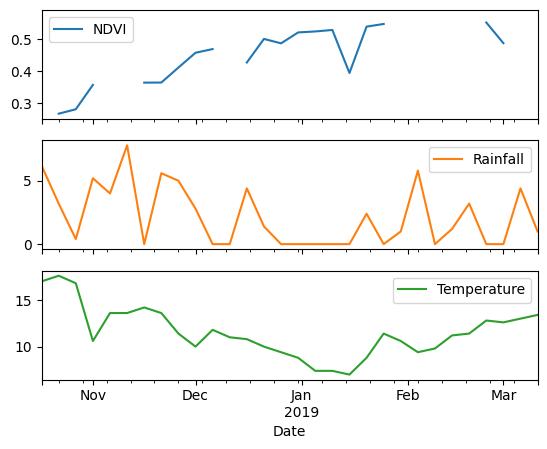

In [ ]:
# view the data in timeseries of the first pixel (optional)
date_time = pd.to_datetime(data_avg.pop('Date'), format='%Y.%m.%d')

plot_cols = ['NDVI', 'Rainfall', 'Temperature']
plot_features = data_avg[plot_cols]
plot_features.index = date_time
_ = plot_features.iloc[:30].plot(subplots=True)

## 3.3 Data clean for table with multiple pixels data

In [ ]:
data_multi = pd.read_csv('/content/drive/MyDrive/merged_table_multi.csv')

In [ ]:
# Select columns to rename
dem_columns = [f'DEM {i}' for i in range(1, 101)]

# Rename columns
new_dem_columns = [f'DEM_{i}' for i in range(1, 101)]
data_multi = data_multi.rename(columns=dict(zip(dem_columns, new_dem_columns)))

In [ ]:
data_multi

### 3.3.1 Interpolation with pchip

In [ ]:
#create list of column names
dem_cols = ['DEM_' + str(i+1) for i in range(100)]

# Group by 'Pixel_ID', check if any DEM value is missing for each group
missing_dem = data_multi.groupby('Pixel_ID')[dem_cols].apply(lambda x: x.isnull().any().any())

# Get the 'Pixel_ID's where no DEM value is missing
valid_pixel_ids = missing_dem[~missing_dem].index

# Filter the original DataFrame to keep only the rows with valid 'Pixel_ID's
data_multi = data_multi[data_multi['Pixel_ID'].isin(valid_pixel_ids)]


In [ ]:
def more_than_half_nan(group):
    ndvi_columns = [f'NDVI_{i}' for i in range(1, 101)]
    ndvi_values = group[ndvi_columns]
    return ndvi_values.isna().mean().mean() > 0.4

# Group by Pixel_ID and apply the function to each group
bad_pixel_ids = data_multi.groupby('Pixel_ID').apply(more_than_half_nan)

# Select only the Pixel_IDs for which the function returned True
bad_pixel_ids = bad_pixel_ids[bad_pixel_ids]

# Count the number of such Pixel_IDs
num_bad_pixel_ids = len(bad_pixel_ids)
print('Number of Pixel_IDs with more than 40% missing NDVI values:', num_bad_pixel_ids)


Number of Pixel_IDs with more than 40% missing NDVI values: 12985


In [ ]:
data_multi = data_multi[~data_multi['Pixel_ID'].isin(bad_pixel_ids.index)]
data_multi = data_multi.reset_index(drop=True)


In [ ]:
data_multi

In [ ]:
#create list of column names
ndvi_cols = ['NDVI_' + str(i+1) for i in range(100)]

# Function to calculate proportion of NDVI values less than 0 for each group
lower_ndvi = data_multi.groupby('Pixel_ID')[ndvi_cols].apply(lambda x: (x.values.flatten() < 0).mean() > 0.1)

# Count how many unique Pixel_IDs have more than 10% of their NDVI values less than 0
num_lower_ndvi = lower_ndvi.sum()

print(f"There are {num_lower_ndvi} unique Pixel_IDs that have more than 10% of their NDVI values less than 0.")


There are 93 unique Pixel_IDs that have more than 10% of their NDVI values less than 0.


In [ ]:
# Filter out Pixel_IDs that have more than 10% of their NDVI values less than 0
data_multi = data_multi[~data_multi['Pixel_ID'].isin(lower_ndvi[lower_ndvi].index)]

# Change NDVI values that are less than 0 to NaN
data_multi[ndvi_cols] = data_multi[ndvi_cols].mask(data_multi[ndvi_cols] < 0)
data_multi = data_multi.reset_index(drop=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# Fill missing rainfall&Temp values using pchip interpolation
data_multi['Rainfall'].interpolate(method='pchip', inplace=True)
data_multi['Temperature'].interpolate(method='pchip', inplace=True)

In [ ]:
# Save the 'Date' column from the original dataframe
dates = data_multi['Date']

In [ ]:
# Fill missing DEM & NDVI values using pchip interpolation
from scipy.interpolate import PchipInterpolator

# Convert the DataFrame to numeric values
data_multi = data_multi.apply(pd.to_numeric, errors='coerce')

# Function to perform PCHIP interpolation
def interpolate_column(column, min_val=None, max_val=None):
    x = column.index
    y = column.values
    mask = pd.isnull(y)
    interpolator = PchipInterpolator(x[~mask], y[~mask])
    y_new = interpolator(x)
    
    # Clip values to a given range if min_val and max_val are provided
    if min_val is not None and max_val is not None:
        y_new = np.clip(y_new, min_val, max_val)
        
    return y_new

# Loop over all DEM and NDVI columns and perform PCHIP interpolation
for i in range(1, 101):
    ndvi_column = f'NDVI_{i}'
    dem_column = f'DEM_{i}'
    
    # Interpolate and clip NDVI values between 0 and 1
    data_multi[ndvi_column] = interpolate_column(data_multi[ndvi_column], 0, 1)
    
    # Interpolate DEM values without clipping
    data_multi[dem_column] = interpolate_column(data_multi[dem_column])

# Remove the 'Date' column
data_multi = data_multi.drop('Date', axis=1)


In [ ]:
# Restore the 'Date' column
data_multi['Date'] = dates
data_multi

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


,Pixel_ID,Timestep,Rainfall,Temperature,NDVI_1,NDVI_2,NDVI_3,NDVI_4,NDVI_5,NDVI_6,...,DEM_92,DEM_93,DEM_94,DEM_95,DEM_96,DEM_97,DEM_98,DEM_99,DEM_100,Date
0,0,1,6.2,17.0,0.256965,0.297766,0.441888,0.443540,0.466343,0.284104,...,215.63052,216.383970,217.23112,218.080150,219.270300,220.76782,221.61310,222.28970,221.65247,2018-10-17
1,0,2,3.2,17.6,0.282991,0.281068,0.329591,0.430013,0.461121,0.413675,...,215.63052,216.383970,217.23112,218.080150,219.270300,220.76782,221.61310,222.28970,221.65247,2018-10-22
2,0,3,0.4,16.8,0.321375,0.291556,0.313549,0.428081,0.465905,0.510159,...,215.63052,216.383970,217.23112,218.080150,219.270300,220.76782,221.61310,222.28970,221.65247,2018-10-27
3,0,4,5.2,10.6,0.370742,0.351911,0.425277,0.550242,0.670167,0.548899,...,215.63052,216.383970,217.23112,218.080150,219.270300,220.76782,221.61310,222.28970,221.65247,2018-11-01
4,0,5,4.0,13.6,0.394024,0.354304,0.418188,0.555165,0.638745,0.554536,...,215.63052,216.383970,217.23112,218.080150,219.270300,220.76782,221.61310,222.28970,221.65247,2018-11-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315775,23677,26,0.6,13.8,0.823835,0.808797,0.800456,0.804700,0.786535,0.805511,...,28.10453,25.575329,25.33952,26.770742,29.394924,32.85262,36.44951,39.11954,41.16403,2019-09-16
315776,23677,27,0.2,9.4,0.828464,0.812876,0.805129,0.808353,0.790403,0.821440,...,28.10453,25.575329,25.33952,26.770742,29.394924,32.85262,36.44951,39.11954,41.16403,2019-09-21
315777,23677,28,0.0,9.2,0.785757,0.721830,0.702783,0.717276,0.723495,0.761289,...,28.10453,25.575329,25.33952,26.770742,29.394924,32.85262,36.44951,39.11954,41.16403,2019-09-26
315778,23677,29,2.0,10.8,0.788245,0.766888,0.740210,0.714003,0.745567,0.795188,...,28.10453,25.575329,25.33952,26.770742,29.394924,32.85262,36.44951,39.11954,41.16403,2019-10-01


In [ ]:
# Find the pixel with missing rainfall/temperature values
unique_pixel_ids_with_missing_dem = data_multi.loc[data_multi['Rainfall'].isna(), 'Pixel_ID'].nunique()
print(f"Number of unique pixel IDs with missing rainfall values: {unique_pixel_ids_with_missing_dem}")


Number of unique pixel IDs with missing rainfall values: 0


In [ ]:
# Find the pixel with missing DEM/NDVI values

missing_pixel_ids = set()

for i in range(1, 101):
    column_name = 'NDVI_' + str(i)
    missing_pixel_ids.update(data_multi.loc[data_multi[column_name].isna(), 'Pixel_ID'])

print(f"Number of unique pixel IDs with missing NDVI values: {len(missing_pixel_ids)}")


Number of unique pixel IDs with missing NDVI values: 0


In [ ]:
ndvi_columns = [f"NDVI_{i}" for i in range(1, 101)]  # Adjust this range according to the actual number of your NDVI columns

# Use pandas DataFrame method 'all' twice to check that all values in all specified columns are within the desired range
all_within_range = data_multi[ndvi_columns].apply(lambda x: (0 <= x) & (x <= 1)).all().all()

print("All NDVI values are within the range of 0 to 1:", all_within_range)


All NDVI values are within the range of 0 to 1: True


In [ ]:
has_nan = data_multi.isna().any().any()
print("NaN values in the DataFrame:", has_nan)

NaN values in the DataFrame: False


In [ ]:
data_multi.to_csv('data_multi_pchip_5.csv', index=False)

### 3.3.2 Interpolation with ARIMA

In [ ]:
!pip install pykrige
from pykrige.ok import OrdinaryKriging

In [ ]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tqdm import tqdm
from pykrige.ok import OrdinaryKriging
from joblib import Parallel, delayed

In [ ]:
data_multi

In [ ]:
pip install statsmodels

In [ ]:
pip install pysal


In [ ]:
pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import pysal.lib
import pandas as pd
import numpy as np

# Convert the DataFrame to numeric values
data_multi = data_multi.apply(pd.to_numeric, errors='coerce')

# Save original min and max values
original_min = data_multi.min()
original_max = data_multi.max()

# Normalize your data
data_multi = (data_multi - original_min) / (original_max - original_min)

# Define spatial weights matrix
W = pysal.lib.weights.lat2W(10, 10)

# Define a function to fit an ARIMA model to each pixel's NDVI and DEM data
# and return a DataFrame of residuals for each pixel
def fit_arima(pixel_data):
    residuals = pd.DataFrame(index=pixel_data.index)
    
    # Loop over all 100 NDVI and DEM columns
    for i in range(1, 101):
        for variable in ['NDVI', 'DEM']:
            column = f'{variable}_{i}'
            
            # Fit an ARIMA model
            model = ARIMA(pixel_data[column], order=(1, 1, 1))
            model_fit = model.fit()
            
            # Save the residuals
            residuals[column] = model_fit.resid
    
    return residuals

# Apply the ARIMA model to each pixel's data and collect residuals
residuals = data_multi.groupby('Pixel_ID').apply(fit_arima)

# Create a DataFrame to store the spatially lagged residuals
spatial_lag = pd.DataFrame(index=residuals.index)

# Loop over all 100 NDVI and DEM columns again to calculate the spatially lagged residuals
for i in range(1, 101):
    for variable in ['NDVI', 'DEM']:
        column = f'{variable}_{i}'
        
        # Calculate the spatially lagged residuals
        spatial_lag[column] = pysal.lib.weights.lag_spatial(W, residuals[column])

# Re-normalize your data back to its original scale:
data_multi = data_multi * (original_max - original_min) + original_min


ModuleNotFoundError: ignored

In [ ]:
has_nan = data_multi_clean.isna().any().any()
print("NaN values in the DataFrame:", has_nan)

NaN values in the DataFrame: True


### 3.3.3 Interpolation with Krig

In [ ]:
pip install scipy numpy pykrige


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from scipy.interpolate import pchip
from pykrige.ok import OrdinaryKriging
from joblib import Parallel, delayed
from tqdm import tqdm

# Convert 'Date' column to datetime and set as index
data_multi['Date'] = pd.to_datetime(data_multi['Date'])
data_multi.set_index('Date', inplace=True)

# Define the x and y coordinates (assuming a 10x10 grid)
x = np.repeat(np.arange(10), 10)
y = np.tile(np.arange(10), 10)

# Get the unique pixel IDs
pixel_ids = data_multi['Pixel_ID'].unique()

In [ ]:

# def process_pixel_id(pixel_id):
#     # Filter the data for the current pixel id
#     data_pixel = data_multi[data_multi['Pixel_ID'] == pixel_id].copy()

#     for i in range(1, 101):  # assuming columns are 1-indexed
#         ndvi_column = f'NDVI_{i}'
#         dem_column = f'DEM {i}'

#         # Get the unique timesteps for the current pixel id
#         timesteps = data_pixel['Timestep'].unique()

#         for timestep in timesteps:
#             # Filter the data for the current timestep
#             data_timestep = data_pixel[data_pixel['Timestep'] == timestep]

#             # Check if there are missing values in the NDVI column
#             if data_timestep[ndvi_column].isnull().any() and len(data_timestep[ndvi_column]) == 100:
#                 # Perform spatial interpolation using Kriging
#                 OK = OrdinaryKriging(x, y, data_timestep[ndvi_column].values, variogram_model='spherical')
#                 z, _ = OK.execute('grid', x, y)

#                 # Replace missing values in the column
#                 data_pixel.loc[data_pixel['Timestep'] == timestep, ndvi_column] = z.ravel()

#             # Check if there are missing values in the DEM column
#             if data_timestep[dem_column].isnull().any() and len(data_timestep[dem_column]) == 100:
#                 # Perform spatial interpolation using Kriging
#                 OK = OrdinaryKriging(x, y, data_timestep[dem_column].values, variogram_model='spherical')
#                 z, _ = OK.execute('grid', x, y)

#                 # Replace missing values in the column
#                 data_pixel.loc[data_pixel['Timestep'] == timestep, dem_column] = z.ravel()

#         # Perform temporal interpolation
#         data_pixel[ndvi_column].interpolate(method='time', inplace=True)
#         data_pixel[dem_column].interpolate(method='time', inplace=True)

#     return data_pixel

# # Perform parallel processing for each pixel id
# interpolated_data = Parallel(n_jobs=-1)(delayed(process_pixel_id)(pixel_id) for pixel_id in tqdm(pixel_ids, desc='Processing pixel ids'))

# # Concatenate the results into the main DataFrame
# data_multi_clean = pd.concat(interpolated_data)

# # Reset the index of the main DataFrame
# data_multi_clean.reset_index(drop=True, inplace=True)


Processing pixel ids: 100%|██████████| 20713/20713 [2:16:50<00:00,  2.52it/s]


In [ ]:
# Find the pixel with missing DEM values
unique_pixel_ids_with_missing_dem = data_multi_clean.loc[data_multi_clean['Rainfall'].isna(), 'Pixel_ID'].nunique()
print(f"Number of unique pixel IDs with missing DEM values: {unique_pixel_ids_with_missing_dem}")


Number of unique pixel IDs with missing DEM values: 0


In [ ]:
for i in range(1, 101):
    column_name = 'NDVI_' + str(i)
    data_multi_clean[column_name].interpolate(method='pchip', inplace=True)

In [ ]:
for i in range(1, 101):
    column_name = 'DEM_' + str(i)
    data_multi_clean[column_name].interpolate(method='pchip', inplace=True)

In [ ]:
missing_pixel_ids = set()

for i in range(1, 101):
    column_name = 'NDVI_' + str(i)
    missing_pixel_ids.update(data_multi_clean.loc[data_multi_clean[column_name].isna(), 'Pixel_ID'])

print(f"Number of unique pixel IDs with missing NDVI values: {len(missing_pixel_ids)}")


Number of unique pixel IDs with missing NDVI values: 1


In [ ]:
missing_pixel_ids = set()

for i in range(1, 101):
    column_name = 'DEM_' + str(i)
    missing_pixel_ids.update(data_multi_clean.loc[data_multi_clean[column_name].isna(), 'Pixel_ID'])

print(f"Number of unique pixel IDs with missing NDVI values: {len(missing_pixel_ids)}")

Number of unique pixel IDs with missing NDVI values: 0


In [ ]:
# Find pixel IDs with any missing value
missing_pixel_ids = data_multi_clean[data_multi_clean.isnull().any(axis=1)]['Pixel_ID'].unique()

# Determine and print the number of such pixel IDs
missing_pixel_id_count = len(missing_pixel_ids)
print(f"Number of pixel IDs with missing data: {missing_pixel_id_count}")


Number of pixel IDs with missing data: 20507


In [ ]:
# Remove rows associated with these pixel IDs
data_multi_clean = data_multi_clean[~data_multi_clean['Pixel_ID'].isin(missing_pixel_ids)]

# Verify that rows with missing values have been removed
assert data_multi_clean.isnull().any(axis=1).sum() == 0

In [ ]:
data_multi_clean

In [ ]:
has_nan = data_multi_clean.isna().any().any()
print("NaN values in the DataFrame:", has_nan)

NaN values in the DataFrame: True


In [ ]:
data_multi_clean.to_csv('data_multi.csv', index=False)

## 3.4 Average NDVI & DEM in one table

In [ ]:
data_multi

In [ ]:
# Identify the NDVI and DEM columns
ndvi_cols = [f"NDVI_{i}" for i in range(1, 101)] 
dem_cols = [f"DEM_{i}" for i in range(1, 101)] 

# Calculate the mean for each row for NDVI and DEM columns separately
data_multi['avg_NDVI'] = data_multi[ndvi_cols].mean(axis=1)
data_multi['avg_DEM'] = data_multi[dem_cols].mean(axis=1)

# Drop the NDVI and DEM columns
data_avg_clean = data_multi.drop(ndvi_cols + dem_cols, axis=1)

In [ ]:
data_avg_clean

,Pixel_ID,Timestep,Rainfall,Temperature,Date,avg_NDVI,avg_DEM
0,1,1,6.4,16.8,2018-10-17,0.459239,225.793652
1,1,2,3.2,17.6,2018-10-22,0.340360,225.793652
2,1,3,0.4,16.6,2018-10-27,0.337288,225.793652
3,1,4,5.0,10.0,2018-11-01,0.479742,225.793652
4,1,5,4.0,13.2,2018-11-06,0.256560,225.793652
...,...,...,...,...,...,...,...
240805,23667,26,0.6,14.0,2019-09-16,0.694676,25.636216
240806,23667,27,0.2,9.6,2019-09-21,0.702523,25.636216
240807,23667,28,0.0,9.2,2019-09-26,0.689789,25.636216
240808,23667,29,2.4,10.6,2019-10-01,0.710349,25.636216


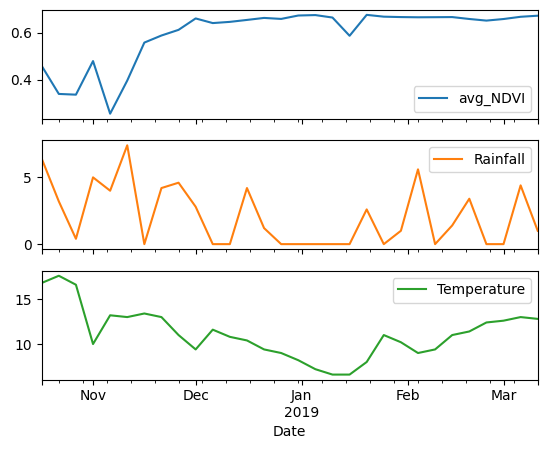

In [ ]:
date_time = pd.to_datetime(data_avg_clean['Date'], format='%Y-%m-%d')

plot_cols = ['avg_NDVI', 'Rainfall', 'Temperature']
plot_features = data_avg_clean[plot_cols]
plot_features.index = date_time
_ = plot_features.iloc[:30].plot(subplots=True)

In [ ]:
# statitics of the datasets
data_avg_clean.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pixel_ID,240810.0,11125.639591,6950.107372,1.000000,5279.000000,8790.000000,16874.000000,23667.000000
Timestep,240810.0,15.500000,8.655459,1.000000,8.000000,15.500000,23.000000,30.000000
Rainfall,240810.0,1.016927,2.003039,0.000000,0.000000,0.000000,1.200000,61.000000
Temperature,240810.0,18.345869,6.256303,-10.200000,13.200000,19.200000,23.400000,33.000000
avg_NDVI,240810.0,0.495967,0.197725,0.000000,0.333080,0.497055,0.651315,0.999615
avg_DEM,240810.0,381.717972,294.886380,-1.249939,158.028263,298.117576,525.480979,1846.124875


In [ ]:
data_avg_clean.to_csv('data_avg_4.csv', index=False)